# Vector store

In [1]:
!pip install -q gensim

In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict, namedtuple

In [2]:
# 1. Parameters
VECTOR_SIZE = 100
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 10000
#MAX_WORDS From https://github.com/piskvorky/gensim/blob/develop/gensim/models/word2vec_inner.pyx#L27

### CustomLineSentence

In [4]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH

In [5]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/text8')

In [ ]:
class CustomWord2Vec:
     def __init__(self, sentences=None, vector_size=100, window=5, min_count=5, workers=3):

          corpus_iterable = sentences

          self.sentences = sentences
          self.vector_size = vector_size
          self.window = window
          self.min_count = min_count
          self.workers = workers

          # from Word2Vec parameters
          self.shrink_windows=True
          self.compute_loss=False
          self.sorted_vocab=1
          self.null_word=0
          self.epochs=5
          self.hashfxn=hash
          self.cbow_mean=1
          self.ns_exponent=0.75
          self.negayive=5
          self.hs=0
          self.sg=0
          self.min_alpha=0.0001
          self.seed=1
          self.sample=0.001
          self.alpha=0.025
          
          # normal init valuse
          self.train_count = 0
          self.total_train_time = 0
          self.running_training_loss = 0
          self.corpus_count = 0
          self.corpus_total_words = 0

          # Main part build vocab
          self.build_vocab(corpus_iterable=corpus_iterable, corpus_file=None, trim_rule=None)


     def scan_vocab(self, sentences=None, corpus_file=None):
          """Scan the corpus to determine the vocabulary size and word frequencies."""
          if corpus_file:
               sentences = CustomLineSentence(corpus_file) # potentially this could be removed - TODO: test this later

          sentence_no = -1         # start from -1 to count the first sentence as 0 in 
          total_words = 0          # 
          vocab = defaultdict(int)

          for sentence_no, sentence in enumerate(sentences):
            for word in sentence:
                vocab[word] += 1
            total_words += len(sentence)

          corpus_count = sentence_no + 1
          self.raw_vocab = vocab

          return total_words, corpus_count

     def build_vocab(self, corpus_iterable, corpus_file=None, trim_rule=None, progress_per=10000):
          # part 1
          
          total_words, corpus_count = self.scan_vocab(sentences=corpus_iterable, corpus_file=corpus_file)
          print(f"Total words: {total_words}, Corpus count: {corpus_count}")
          self.corpus_count = corpus_count
          self.corpus_total_words = total_words
          
          # part 2 

          report_values = self.prepare_vocab()



     def train():
          pass
          


In [20]:
model = CustomWord2Vec(
    sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS
)

Total words: 17005207, Corpus count: 1701


In [5]:

# 3. Train Word2Vec
model = Word2Vec(
    sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS
)

# 4. Save the trained model
model.save('models/text8_w2v_100d.model')

# 5. Quick sanity check
print(model.wv.most_similar('king', topn=10))

hello im here 1
hello im here
corpus_count 1701 total_words 17005207
hello im here
[('prince', 0.7644685506820679), ('emperor', 0.7196422815322876), ('queen', 0.7034397721290588), ('kings', 0.6848741173744202), ('throne', 0.6829399466514587), ('vii', 0.6726424098014832), ('pope', 0.6720109581947327), ('antiochus', 0.6700108051300049), ('elector', 0.6592143774032593), ('tsar', 0.6487392783164978)]


# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give ir n_components of 3 to give it a 3 dim.

In my test case we just test the first 300 words as we have a lot of them.

Also what i can see when i look at the data we have alot of word that are stopwords, we are going to want to remove them.

(71290, 100)


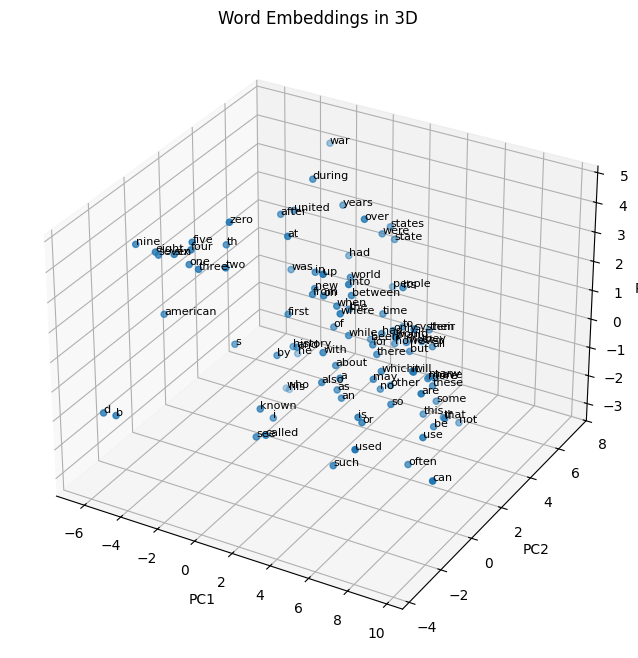

In [ ]:
from sklearn.decomposition import PCA

weights = model.wv.vectors

print(weights.shape)  # (number of words, vector size)
import matplotlib.pyplot as plt

# Reduce vectors to 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

# Plot the first 100 words in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights_3d[:100, 0], weights_3d[:100, 1], weights_3d[:100, 2])

# Annotate points with words
words = list(model.wv.index_to_key)
for i in range(100):
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], words[i], size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Word Embeddings in 3D')
plt.show()
